In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from scipy.spatial.distance import squareform

import sys
utils_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/streams/utils/'
sys.path.append(utils_dir)

from rsm_utils import get_flat_lower_tri, make_flat_rsms

In [3]:
##https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
    
def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

In [4]:
data_dir = '../../../data/'
local_data_dir = '../../../local_data/'

subjid = ['05']
n_repeats = 3

#threshold for voxels (based on split-half reliability)
thresh = 0 #0.1 #0.2

In [5]:
with open(local_data_dir + 'processed/05_rh_tessellate_300.data', 'rb') as filehandle:
    # read the data as binary data stream
    mega_matrix = pickle.load(filehandle)

In [6]:
test = mega_matrix[0]
test[test>1] = 1
test[np.isnan(test)] = 0

In [7]:
len(test)

68

In [8]:
test[np.diag_indices(len(test))] = 1 #fix diagonal

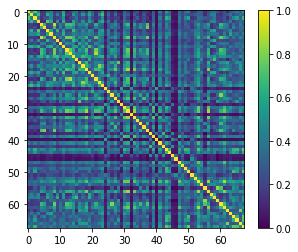

In [9]:
plt.imshow(test)
plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

In [10]:
sym_mm = np.around(test, decimals = 5)
dists = squareform(1-sym_mm)

Method:	 ward


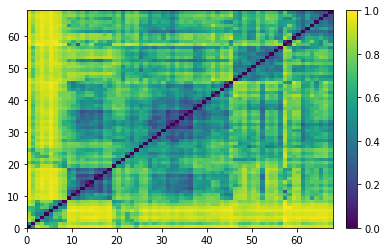

Method:	 single


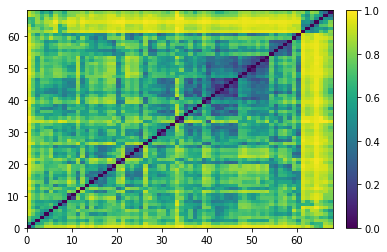

Method:	 average


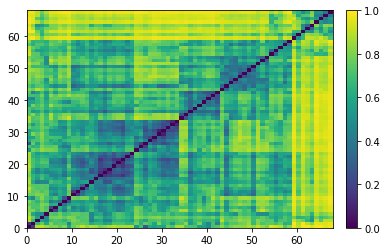

Method:	 complete


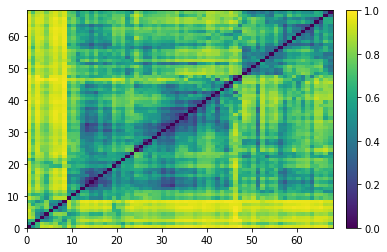

In [11]:
methods = ["ward","single","average","complete"]
N = len(sym_mm)
for method in methods:
    print("Method:\t",method)
    
    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(1-sym_mm,method)
    
    plt.pcolormesh(ordered_dist_mat)
    plt.xlim([0,N])
    plt.ylim([0,N])
    plt.clim(0,1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

In [35]:
linkage_matrix = linkage(dists, "average", optimal_ordering=True) #complete


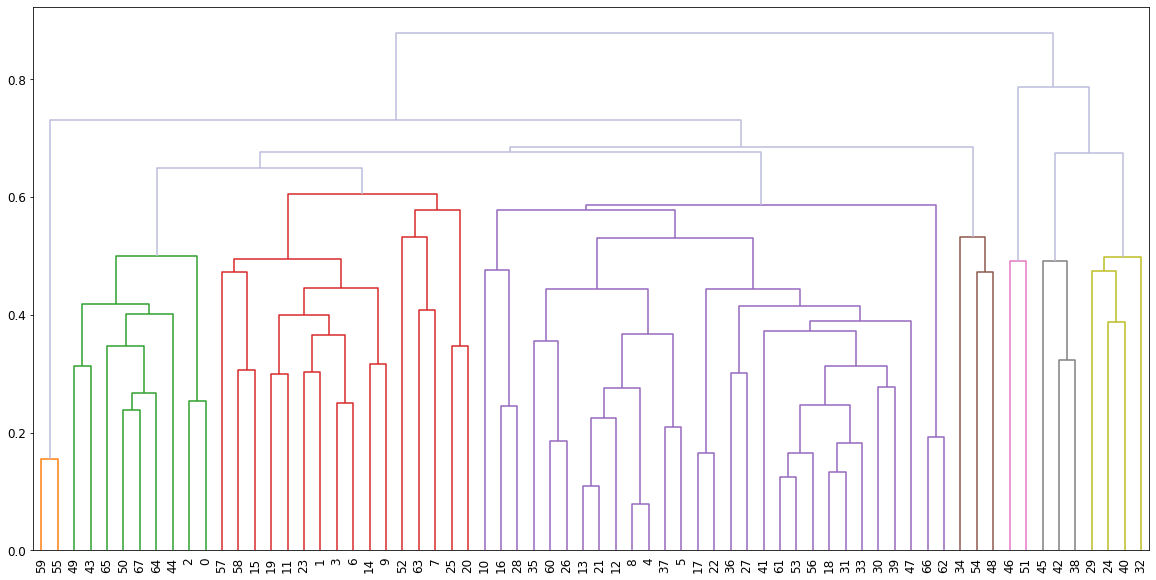

In [36]:
plt.figure(figsize=(20,10))

dn = dendrogram(linkage_matrix, 
                above_threshold_color='#bcbddc',
                leaf_rotation=90.,
                leaf_font_size=12.)  
plt.gca().yaxis.set_tick_params(labelsize='large')

In [37]:
roi_order = list(map(int, dn['ivl'])) #convert from strings to ints
cluster_colors = np.zeros((4, len(roi_order)))

In [38]:
#convert the dendrogram colors to indices we can use for ROI coloring
color_indices = np.zeros((len(dn['leaves_color_list'])))
count = 1
for c in range(len(dn['leaves_color_list'])):
    if dn['leaves_color_list'][c] in "#bcbddc":
        color_indices[c] = 0
    else:
        if c == 0:
            color_indices[c] = count
        else:
            if dn['leaves_color_list'][c] == dn['leaves_color_list'][c-1] or dn['leaves_color_list'][c-1] in "#bcbddc":
                color_indices[c] = count
            else:
                count += 1
                color_indices[c] = count
        

In [39]:
clusters_by_roi = [int(x) for _,x in sorted(zip(roi_order,color_indices))]

In [40]:
#create dict for matlab
ordered_clusters = {}
ordered_clusters['full'] = clusters_by_roi

#save out
save_dir = '../../../local_data/processed'
scipy.io.savemat(save_dir + '/subj05_rh_300_cluster_testing.mat', ordered_clusters)

In [18]:
first_half_split = dn['ivl'].index('32') +1
q1_split = dn['ivl'].index('51') +1
q3_split = dn['ivl'].index('10') +1

In [19]:
cluster_colors[0,:] = np.hstack((np.repeat(0,first_half_split), np.repeat(1,len(roi_order)-first_half_split)))

In [20]:
cluster_colors[1,:] = np.hstack((np.repeat(0,q1_split), np.repeat(1,first_half_split-q1_split),
                                 np.repeat(2,q3_split-first_half_split),np.repeat(3,len(roi_order)-q3_split)))

In [21]:
cluster_splits = np.zeros_like((cluster_colors))
for c in range(2):
    cluster_splits[c,:] = [x for _,x in sorted(zip(roi_order,cluster_colors[c]))]

#create dict for matlab
ordered_clusters = {}
ordered_clusters['split1'] = cluster_splits[0]
ordered_clusters['split2'] = cluster_splits[1]

#save out
save_dir = '../../../local_data/processed'
scipy.io.savemat(save_dir + '/subj05_rh_cluster_testing_300.mat', ordered_clusters)

In [ ]:
#next split level
#s1 = dn['ivl'].index('20') +1
#s2 = dn['ivl'].index('63') +1
#s3 = dn['ivl'].index('44') +1
#s4 = dn['ivl'].index('0') +1
#s5 = dn['ivl'].index('5') +1
#s6 = dn['ivl'].index('28') +1
#s7 = dn['ivl'].index('34') +1
#s8 = end


In [ ]:
#cluster_colors[2,:] = np.hstack((np.repeat(0,s1), np.repeat(1,s2-s1), np.repeat(2,s3-s2),
#                                 np.repeat(3,s4-s3), np.repeat(4,s5-s4), np.repeat(5,s6-s5),
#                                 np.repeat(6,s7-s6), np.repeat(7,len(roi_order)-s7)))

In [ ]:
#all groups based on dendrogram coloring
#g1 = s1 +1
#g2 = s2 +1
#g3 = s3 +1
#g4 = s4 +1
#g5 = s5 +1
#g6 = dn['ivl'].index('25') +1
#g7 = s6 +1
#g8 = dn['ivl'].index('42') +1
#g9 = dn['ivl'].index('34') +1


In [ ]:
#cluster_colors[3,:] = np.hstack((np.repeat(1,g1), np.repeat(2,g2-g1), np.repeat(3,g3-g2),
#                                np.repeat(4,g4-g3), np.repeat(5,g5-g4), np.repeat(6,g6-g5),
#                                 np.repeat(7,g7-g6), np.repeat(8,g8-g7), np.repeat(9,g9-g8), 
#                                 np.repeat(10,len(roi_order)-g9)))
#cluster_colors[3,dn['ivl'].index('24')] = 0 #no grouping

In [ ]:
#cluster_colors

In [ ]:
#clusters_by_roi = np.zeros_like((cluster_colors))

In [ ]:
#for c in range(4):
#    clusters_by_roi[c,:] = [x for _,x in sorted(zip(roi_order,cluster_colors[c]))]

In [ ]:
#clusters_by_roi

In [ ]:
#create dict for matlab
#ordered_clusters = {}
#ordered_clusters['split1'] = clusters_by_roi[0]
#ordered_clusters['split2'] = clusters_by_roi[1]
#ordered_clusters['split3'] = clusters_by_roi[2]
#ordered_clusters['split4'] = clusters_by_roi[3]

#save out
#save_dir = '../../../local_data/processed'
#scipy.io.savemat(save_dir + '/subj06_rh_cluster_testing.mat', ordered_clusters)

In [22]:
from sklearn.manifold import MDS
x, y = MDS(dissimilarity='precomputed').fit_transform(1-test).T

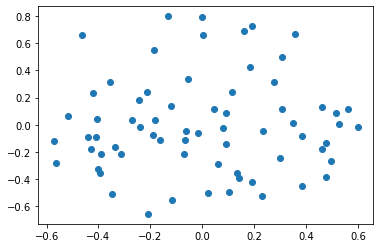

In [23]:
plt.scatter(x, y)

In [24]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans


In [25]:
clustering = AffinityPropagation(affinity='precomputed',random_state=5).fit_predict(test)

In [26]:
affinity_prop = {}
affinity_prop['ap'] = clustering

#save out
save_dir = '../../../local_data/processed'
scipy.io.savemat(save_dir + '/subj05_rh_ap_testing.mat', affinity_prop)

In [27]:
clustering

array([10,  0, 10,  0,  1,  1,  0,  0,  1,  8,  2,  0,  1,  1,  1,  8,  2,
        4,  4,  8,  7,  1,  4,  0,  3,  7,  9,  4,  2,  3,  7,  4,  3,  4,
        7,  9,  4,  1,  5,  7,  3,  7,  5, 10, 10,  5,  6,  7,  7,  7, 10,
        6,  4,  7,  7,  9,  4,  8,  8, 10,  9,  7,  2,  7, 10, 10,  4, 10])

In [ ]:
kmeans_s = KMeans(n_clusters=5, random_state=0).fit(test)

In [ ]:
kmeans_s.labels_

In [ ]:
kmeans_match = KMeans(n_clusters=14, random_state=0).fit(test)

In [ ]:
kmeans_match.labels_

In [ ]:
kmeans = {}
kmeans['k7'] = kmeans_s.labels_
kmeans['k14'] = kmeans_match.labels_

#save out
save_dir = '../../../local_data/processed'
scipy.io.savemat(save_dir + '/subj06_rh_kmeans_testing.mat', kmeans)